# Generate strata

In [100]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import xarray as xr

from sklearn import cluster

## Read in temp and color data

In [101]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_clean_path = repo_path / 'data/clean/'
data_raw_path = repo_path / 'data/raw/'
geo_crs = 'epsg:4326'
proj_crs = 'EPSG:3395'

In [105]:
# read data
t_raw = pd.read_csv(data_clean_path / 'oisst.csv')
c_raw = pd.read_csv(data_clean_path / 'chlor_a.csv')

In [106]:
# make geodataframes
# sst
geo = [Point(lon, lat) for lat, lon in zip(t_raw.lat, t_raw.lon)]
t_gpd = gpd.GeoDataFrame(t_raw, geometry=geo, crs=proj_crs)

In [107]:
# color
geo = [Point(lon, lat) for lat, lon in zip(c_raw.lat, c_raw.lon)]
c_gpd = gpd.GeoDataFrame(c_raw, geometry=geo, crs=proj_crs)

In [ ]:
print('SST dataset:', t_gpd.shape)
print('Color dataset:', c_gpd.shape)
rs = t_gpd.sjoin(right=c_gpd, how='inner')
print('Merged dataset:', rs.shape)

In [94]:
rs = rs.set_crs(geo_crs, allow_override=True)

In [110]:
rs.columns

Index(['pacific_left', 'lat_left', 'lon_left', 'std_left', 'mean_left',
       'max_left', 'min', 'geometry', 'index_right', 'pacific_right',
       'lat_right', 'lon_right', 'std_right', 'max_right', 'mean_right',
       'below_mean', 'months_below_mean', 'bimodal_chl'],
      dtype='object')

In [165]:
X = c_gpd.loc[c_gpd.pacific][['lat', 'lon', 'bimodal_chl']]
X = X.transform(lambda x: (x - np.mean(x))/np.std(x))

In [166]:
kmeans = cluster.KMeans(n_clusters=8, random_state=0)
kmeans.fit(X)

KMeans(random_state=0)

In [ ]:
# impose a connectivity constraint
# agclust = cluster.AgglomerativeClustering(n_clusters=4, )

In [167]:
pac = c_gpd.loc[c_gpd.pacific]

In [168]:
pac['clusters'] = kmeans.labels_

/Users/etriesch/.pyenv/versions/3.9.5/envs/venv.ocean-carbon-sampling/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:>

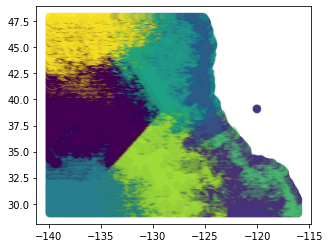

In [169]:
pac.plot(column='clusters', alpha=0.1)

## Subset to sample zones

In [84]:
# load coastlines (saved locally)
coast_fp = data_raw_path / 'tufts-contuscoastline14-shapefile.zip'
boundary_fp = data_raw_path / 'stanford-vg541kt0643-shapefile.zip'
coast = gpd.read_file(data_raw_path / coast_fp).to_crs(geo_crs)
boundary = gpd.read_file(data_raw_path / boundary_fp).to_crs(geo_crs)

In [60]:
# Monterrey desal mask
ca_cent = [-121.788649, 36.802834]
ca_lats = [33.48, 39.48]
ca_lons = [-125.48, -119.48]
# Texas desal mask
tx_cent = [-95.311296, 28.927239]
tx_lats = [25.57, 31.57]
tx_lons = [-98.21, -92.21]
# NH desal mask
nh_cent = [-70.799678, 42.563588]
nh_lats = [39.38, 45.38]
nh_lons = [-73.50, -67.50]

In [96]:
# make disks
BUFFER = 1.5
ca_disc = gpd.GeoSeries(Point(ca_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
ca_disc = gpd.GeoDataFrame(geometry=ca_disc)
tx_disc = gpd.GeoSeries(Point(tx_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
tx_disc = gpd.GeoDataFrame(geometry=tx_disc)
nh_disc = gpd.GeoSeries(Point(nh_cent), crs=proj_crs).buffer(BUFFER).set_crs(geo_crs, allow_override=True)
nh_disc = gpd.GeoDataFrame(geometry=nh_disc)
# cut discs at coastal boundary
ca = ca_disc.overlay(boundary, how='difference')
tx = tx_disc.overlay(boundary, how='difference')
nh = nh_disc.overlay(boundary, how='difference')